# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot

In [4]:
import pickle

def load_pickled_data(file, columns = ['features', 'labels']):
    """
    Loads pickled training and test data.

    Returns
    -------
    A tuple of X_train, y_train and X_test, y_test datasets.    
    """

    with open(file, mode='rb') as f:
        dataset = pickle.load(f)
    
    return tuple(map(lambda c: dataset[c], columns))

In [46]:
train_dataset_file = "traffic-signs-data/train.p"
test_dataset_file = "traffic-signs-data/test.p"

X_train, y_train, sizes, positions = load_pickled_data(train_dataset_file, ['features', 'labels', 'sizes', 'coords'])
X_test, y_test = load_pickled_data(test_dataset_file)

n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [47]:
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]

### Original photos

Let's first explore data about original photos. Who knows — maybe we can spot some data correlations with signs positions in the photos or positions across specific sign classes.

Let's first plot histograms of original photos' sizes.

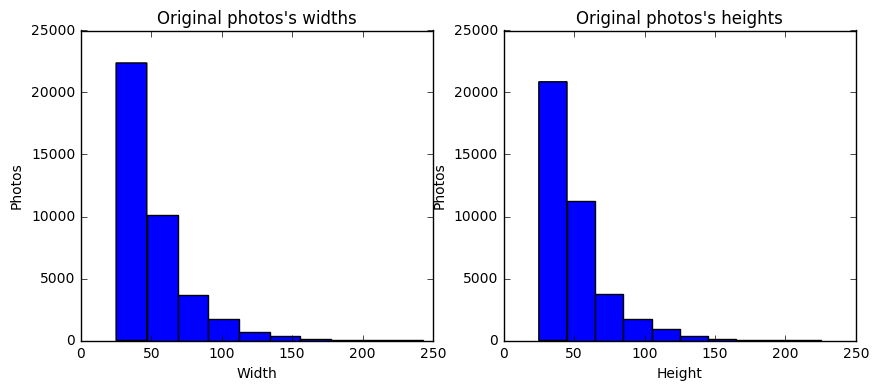

In [48]:
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]
sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(sizes[:, 0])
pyplot.title('Original photos\'s widths')
pyplot.xlabel('Width')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(sizes[:, 1])
pyplot.title('Original photos\'s heights')
pyplot.xlabel('Height')
pyplot.ylabel('Photos')

pyplot.show()

Doesn't look too promising — apparently photos are of all different sizes, majority ranging from ~30 to ~150 px both width and height. Actually both histograms looks surprisingly similar, I bet aspect ratios of all photos are close to 1. Let's check it out!

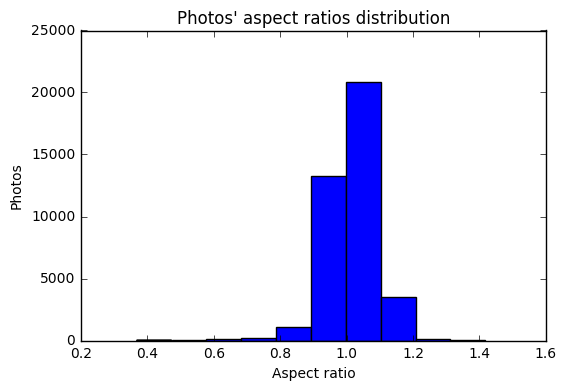

In [49]:
sizes_figure = pyplot.figure()
axis = sizes_figure.add_subplot(1, 1, 1)
axis.hist(sizes[:, 0]/sizes[:, 1])
pyplot.title('Photos\' aspect ratios distribution')
pyplot.xlabel('Aspect ratio')
pyplot.ylabel('Photos')
pyplot.show()

There you go! Vast majority of original photos had aspect ratio ranging from 0.9 to 1.2, e.g. almost all photos were more or less square.

Let's check how much area of the original image did signs occupy? In other words, to which extent did we have to crop the original photo to get the sign out of it. Again, let's check for both width and height by calculating sign dimensions as fractions of original photo dimensions.

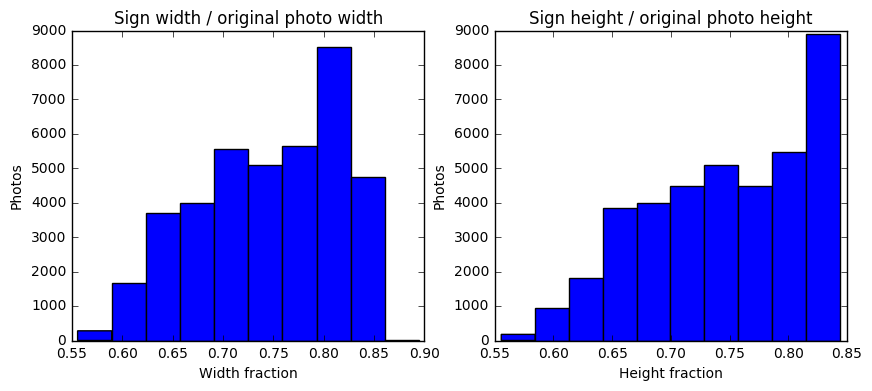

In [50]:
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]

sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(width_fraction)
pyplot.title('Sign width / original photo width')
pyplot.xlabel('Width fraction')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(height_fraction)
pyplot.title('Sign height / original photo height')
pyplot.xlabel('Height fraction')
pyplot.ylabel('Photos')

pyplot.show()

In [51]:
from scipy import stats

def print_stats(array, label):
    _, minmax, mean, variance, _, _ = stats.describe(array)
    margin = int((40 - len(label))/2)
    for i in range(margin*2): 
        if i == margin: print(label.upper(), end="")
        print("=", end="")    
    print()

    print("  %-*s %s" % (15, "Min:", str(minmax[0])))
    print("  %-*s %s" % (15, "Max:", str(minmax[1])))
    print("  %-*s %s" % (15, "Mean:", str(mean)))
    print("  %-*s %s" % (15, "Variance:", str(variance)))
    
    print()
    
print_stats(width_fraction, " sign_width / photo_width ")
print_stats(height_fraction, " sign_height / photo_height ")

======= SIGN_WIDTH / PHOTO_WIDTH =======
  Min:            0.555555555556
  Max:            0.894736842105
  Mean:           0.746511557333
  Variance:       0.00480405637618

====== SIGN_HEIGHT / PHOTO_HEIGHT ======
  Min:            0.555555555556
  Max:            0.84375
  Mean:           0.746647947364
  Variance:       0.00467049069312



Not really promising either. All photos had almost nothing but signs in them, for both width and height signs occupied at least half of the dimension, and for majority of samples signs occupied around 75% of the photo.

Now, if we found any uneven distributions in the dataset I would be tempted to try and analyze it on per-class basis. Although for now data looks pretty homogeneous and I doubt there will be any meaningful patterns related to specific classes based on the original samples' images.

### Sample images

Ok, let's check out the sign samples. We will go through all dataset classes, noting number of samples and plotting 10 random images representing each class.

Class 0: Speed limit (20km/h)                                210 samples


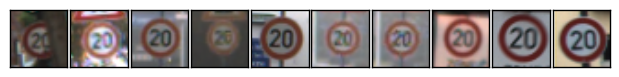

--------------------------------------------------------------------------------------

Class 1: Speed limit (30km/h)                                2220 samples


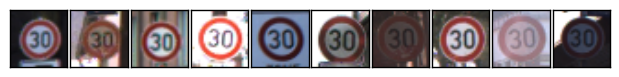

--------------------------------------------------------------------------------------

Class 2: Speed limit (50km/h)                                2250 samples


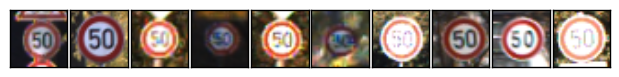

--------------------------------------------------------------------------------------

Class 3: Speed limit (60km/h)                                1410 samples


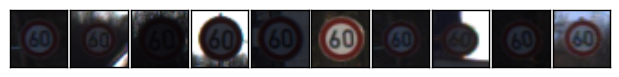

--------------------------------------------------------------------------------------

Class 4: Speed limit (70km/h)                                1980 samples


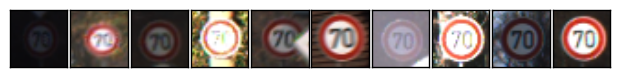

--------------------------------------------------------------------------------------

Class 5: Speed limit (80km/h)                                1860 samples


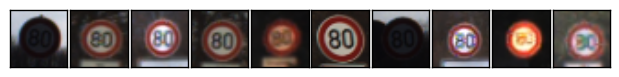

--------------------------------------------------------------------------------------

Class 6: End of speed limit (80km/h)                         420 samples


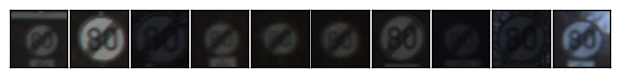

--------------------------------------------------------------------------------------

Class 7: Speed limit (100km/h)                               1440 samples


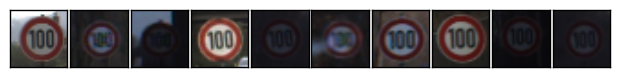

--------------------------------------------------------------------------------------

Class 8: Speed limit (120km/h)                               1410 samples


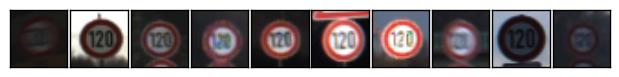

--------------------------------------------------------------------------------------

Class 9: No passing                                          1470 samples


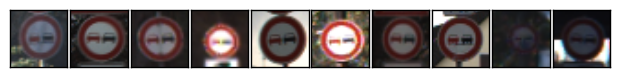

--------------------------------------------------------------------------------------

Class 10: No passing for vechiles over 3.5 metric tons        2010 samples


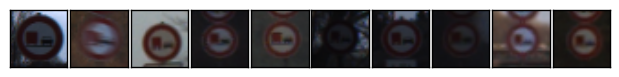

--------------------------------------------------------------------------------------

Class 11: Right-of-way at the next intersection               1320 samples


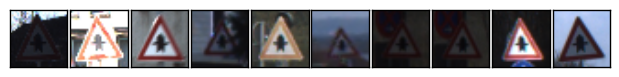

--------------------------------------------------------------------------------------

Class 12: Priority road                                       2100 samples


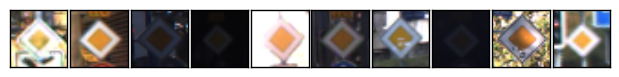

--------------------------------------------------------------------------------------

Class 13: Yield                                               2160 samples


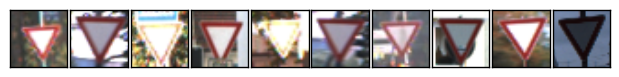

--------------------------------------------------------------------------------------

Class 14: Stop                                                780 samples


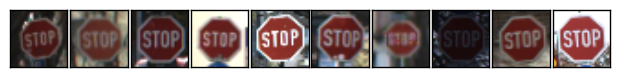

--------------------------------------------------------------------------------------

Class 15: No vechiles                                         630 samples


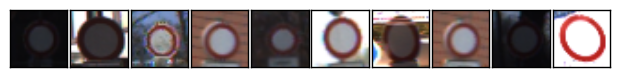

--------------------------------------------------------------------------------------

Class 16: Vechiles over 3.5 metric tons prohibited            420 samples


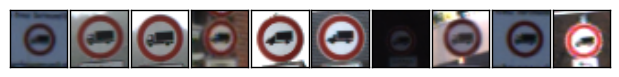

--------------------------------------------------------------------------------------

Class 17: No entry                                            1110 samples


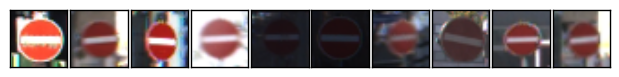

--------------------------------------------------------------------------------------

Class 18: General caution                                     1200 samples


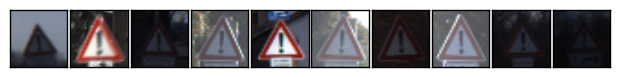

--------------------------------------------------------------------------------------

Class 19: Dangerous curve to the left                         210 samples


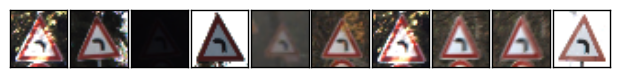

--------------------------------------------------------------------------------------

Class 20: Dangerous curve to the right                        360 samples


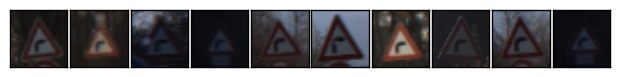

--------------------------------------------------------------------------------------

Class 21: Double curve                                        330 samples


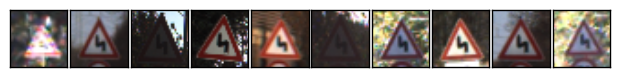

--------------------------------------------------------------------------------------

Class 22: Bumpy road                                          390 samples


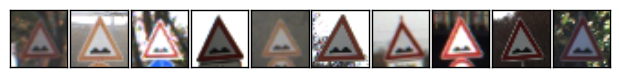

--------------------------------------------------------------------------------------

Class 23: Slippery road                                       510 samples


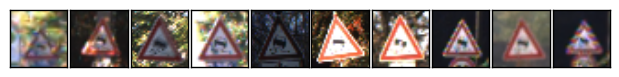

--------------------------------------------------------------------------------------

Class 24: Road narrows on the right                           270 samples


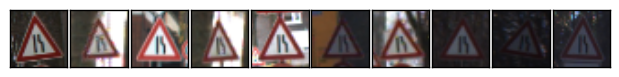

--------------------------------------------------------------------------------------

Class 25: Road work                                           1500 samples


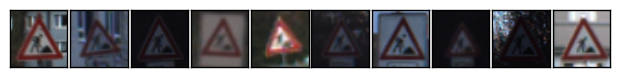

--------------------------------------------------------------------------------------

Class 26: Traffic signals                                     600 samples


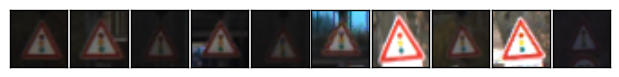

--------------------------------------------------------------------------------------

Class 27: Pedestrians                                         240 samples


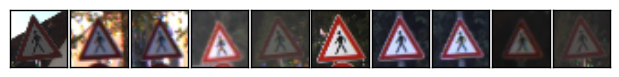

--------------------------------------------------------------------------------------

Class 28: Children crossing                                   540 samples


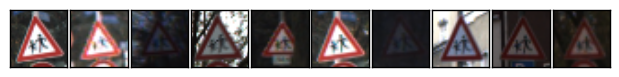

--------------------------------------------------------------------------------------

Class 29: Bicycles crossing                                   270 samples


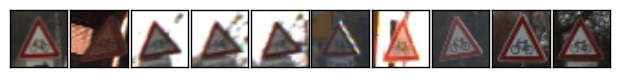

--------------------------------------------------------------------------------------

Class 30: Beware of ice/snow                                  450 samples


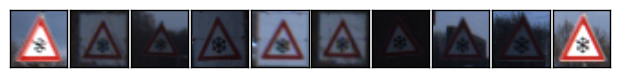

--------------------------------------------------------------------------------------

Class 31: Wild animals crossing                               780 samples


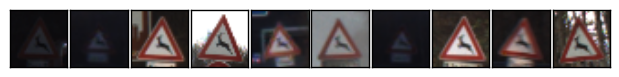

--------------------------------------------------------------------------------------

Class 32: End of all speed and passing limits                 240 samples


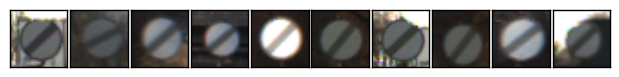

--------------------------------------------------------------------------------------

Class 33: Turn right ahead                                    689 samples


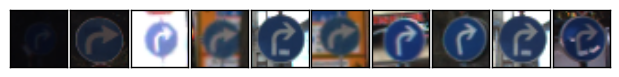

--------------------------------------------------------------------------------------

Class 34: Turn left ahead                                     420 samples


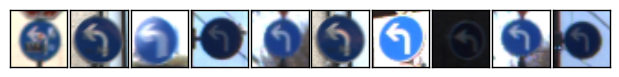

--------------------------------------------------------------------------------------

Class 35: Ahead only                                          1200 samples


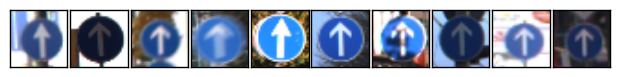

--------------------------------------------------------------------------------------

Class 36: Go straight or right                                390 samples


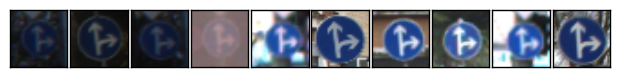

--------------------------------------------------------------------------------------

Class 37: Go straight or left                                 210 samples


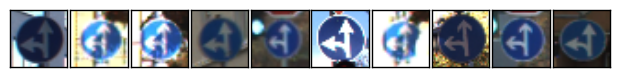

--------------------------------------------------------------------------------------

Class 38: Keep right                                          2070 samples


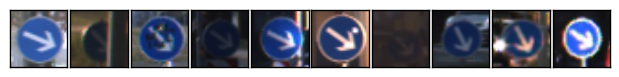

--------------------------------------------------------------------------------------

Class 39: Keep left                                           300 samples


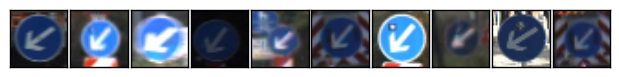

--------------------------------------------------------------------------------------

Class 40: Roundabout mandatory                                360 samples


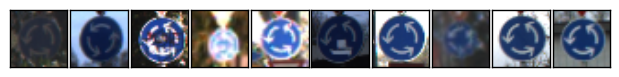

--------------------------------------------------------------------------------------

Class 41: End of no passing                                   240 samples


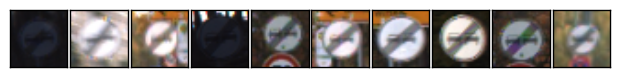

--------------------------------------------------------------------------------------

Class 42: End of no passing by vechiles over 3.5 metric tons  240 samples


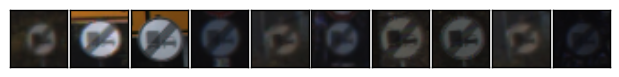

--------------------------------------------------------------------------------------



In [52]:
import random

col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print("--------------------------------------------------------------------------------------\n")

**Bad news**: Some classes are highly underrepresented. Overall amount of data is disappointing: some classes have as little as 210 samples, this won't be enough for most of the models to generalise well.

**Good news**: There is a room for data augmentation.

Images with some signs are horizontally symmetrical (like **Bumpy road** or **Ahead only**), and can be simply flipped horizontally, thus allowing us to get twice as much data for these classes. 

Other signs come in kind of interchageable pairs, like **Keep right** and **Keep left**: those signs can be flipped and assigned to a paired class. In some cases (like **Keep right** and **Keep left**) we increase the number of samples for **Keep left** from 300 to 2370!

CNNs have built-in invariance to small translations, scaling and rotations. The training set doesn't seem to contain those deformations, so we will add those in our data augmentation step as well.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [54]:
from sklearn.utils import shuffle

def preprocess_dataset(X, y = None):
    """
    Performs feature scaling, one-hot encoding of labels and shuffles the data if labels are provided.
    
    Parameters
    ----------
    X     : ndarray
            Dataset array containing feature examples.
    y     : ndarray, optional, defaults to `None`
            Dataset labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """

    # Convert to grayscale, e.g. single channel
    X = 0.2125 * X[:, :, :, 0] + 0.7154 * X[:, :, :, 1] + 0.0721 * X[:, :, :, 2]
    # Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)

    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(n_classes)[y]
        X, y = shuffle(X, y, random_state = 42)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

In [55]:
from sklearn.cross_validation import train_test_split

# Load pickled data
X_train, y_train = load_pickled_data(train_dataset_file)
X_test, y_test = load_pickled_data(test_dataset_file)

# Preprocess initial data by scaling features, shiffling the data, etc.
X_test, y_test = preprocess_dataset(X_test, y_test)
X_train, y_train = preprocess_dataset(X_train, y_train)

# Use 20% of the training dataset for validation.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

print("Number of training examples =", y_train.shape[0])
print("Number of validation examples =", y_valid.shape[0])
print("Number of testing examples =", y_test.shape[0])
print("Image data shape =", X_train[0].shape)

Number of training examples = 31367
Number of validation examples = 7842
Number of testing examples = 12630
Image data shape = (32, 32, 1)


In [43]:
from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.util import random_noise
from skimage.exposure import adjust_gamma
from skimage.filters import gaussian

class AugmentedSignsBatchIterator(BatchIterator):
    
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped horizontally, should still be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39]
    ])
      
    def __init__(self, batch_size, shuffle = False, seed = 42):
        super(AugmentedSignsBatchIterator, self).__init__(batch_size, shuffle, seed)
        
        # Total number of classes    
        num_classes = 43
            
        # Generate a conversion matrix for the one-hot encoded `y` when flipping the image.
        self.y_flip_conversion = np.zeros((num_classes, num_classes))
        self.y_flip_conversion[self.self_flippable, self.self_flippable] = 1.
        self.y_flip_conversion[self.cross_flippable[:, 0], self.cross_flippable[:, 1]] = 1.
        self.y_flip_conversion[self.cross_flippable[:, 1], self.cross_flippable[:, 0]] = 1.
        
        # Create a list of all flippable classes.
        self.flippable = np.append(self.self_flippable, self.cross_flippable.flatten())

    def transform(self, Xb, yb):
        Xb, yb = super(AugmentedSignsBatchIterator, self).transform(
            Xb if yb is None else Xb.copy(), 
            None if yb is None else yb.copy()
        )

        batch_size = Xb.shape[0]
        image_size = Xb.shape[1]
        
        if yb is not None:
            Xb = self.rotate(Xb, batch_size)
            Xb = self.apply_projection_transform(Xb, batch_size, image_size)
            Xb = self.adjust_gamma(Xb, batch_size)
            Xb = self.blur(Xb, batch_size)
            #Xb = self.add_noize(Xb, batch_size)
            Xb, yb = self.flip_horizontally(Xb, yb, batch_size)

        return Xb, yb
    
    def flip_horizontally(self, Xb, yb, batch_size, p = 0.5):
        # Get a mask of randomly chosen half of elements
        random_choice_indices = np.random.choice(batch_size, int(batch_size * p), replace = False)
        random_choice_mask = np.zeros(batch_size, dtype = bool)
        random_choice_mask[random_choice_indices] = True
        
        # Get a mask of flippable elements in current batch
        flippable_mask = np.in1d(yb.nonzero()[1], self.flippable)
        
        # Get an intersection mask of randomly chosen AND flippable elements
        flip_mask = random_choice_mask & flippable_mask
        
        # Flip images and flip labels as well, if requried. The `y_flip_conversion` is going to take care of that.
        Xb[flip_mask] = Xb[flip_mask, :, ::-1, :]
        yb[flip_mask] = np.transpose(np.dot(self.y_flip_conversion, np.transpose(yb[flip_mask])))
        
        return Xb, yb
        
    def rotate(self, Xb, batch_size, p = 0.5):
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = rotate(Xb[i], random.uniform(-15., 15.), mode = 'edge')
        return Xb 
    
    def add_noize(self, Xb, batch_size, p = 0.5):
        modes = ["gaussian", "localvar", "poisson", "speckle"] # Excluding "salt", "pepper", "s&p" for now
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = random_noise(Xb[i], mode = random.choice(modes))
        return Xb
    
    def adjust_gamma(self, Xb, batch_size, p = 0.5):
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = adjust_gamma(Xb[i], gamma = random.uniform(0.5, 1.5))
        return Xb        

    def blur(self, Xb, batch_size, p = 0.5):
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = gaussian(Xb[i], sigma = random.uniform(0., 0.8))
        return Xb   
    
    def apply_projection_transform(self, Xb, batch_size, image_size, p = 0.5):
        d = image_size * 0.1
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):        
            tl_top = random.uniform(-d, d)
            tl_left = random.uniform(-d, d)
            bl_bottom = random.uniform(-d, d)
            bl_left = random.uniform(-d, d)
            tr_top = random.uniform(-d, d)
            tr_right = random.uniform(-d, d)
            br_bottom = random.uniform(-d, d)
            br_right = random.uniform(-d, d)

            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            Xb[i] = warp(Xb[i], transform, output_shape=(image_width, image_height), mode = 'edge')

        return Xb

Source class: General caution
 Batch class: General caution


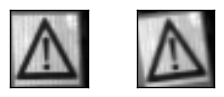

Source class: Yield
 Batch class: Yield


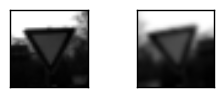

Source class: Speed limit (50km/h)
 Batch class: Speed limit (50km/h)


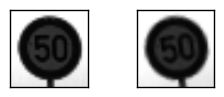

Source class: Speed limit (80km/h)
 Batch class: Speed limit (80km/h)


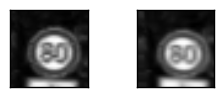

Source class: Speed limit (60km/h)
 Batch class: Speed limit (60km/h)


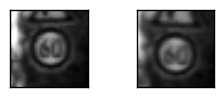

Source class: Speed limit (30km/h)
 Batch class: Speed limit (30km/h)


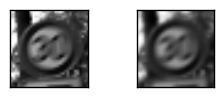

Source class: Speed limit (80km/h)
 Batch class: Speed limit (80km/h)


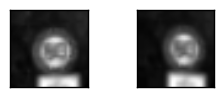

Source class: No passing for vechiles over 3.5 metric tons
 Batch class: No passing for vechiles over 3.5 metric tons


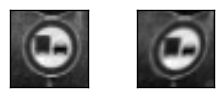

Source class: No passing
 Batch class: No passing


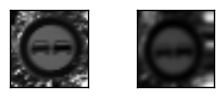

Source class: No passing
 Batch class: No passing


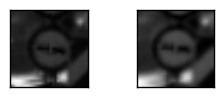

Source class: Right-of-way at the next intersection
 Batch class: Right-of-way at the next intersection


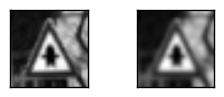

Source class: Slippery road
 Batch class: Slippery road


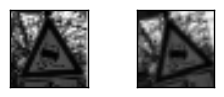

Source class: Speed limit (120km/h)
 Batch class: Speed limit (120km/h)


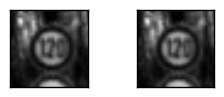

Source class: No passing for vechiles over 3.5 metric tons
 Batch class: No passing for vechiles over 3.5 metric tons


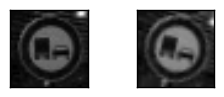

Source class: Speed limit (60km/h)
 Batch class: Speed limit (60km/h)


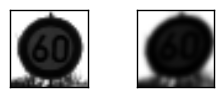

Source class: Stop
 Batch class: Stop


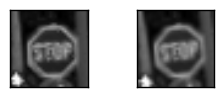

Source class: Turn left ahead
 Batch class: Turn right ahead


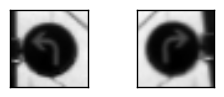

Source class: Speed limit (50km/h)
 Batch class: Speed limit (50km/h)


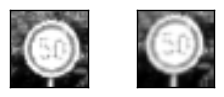

Source class: Double curve
 Batch class: Double curve


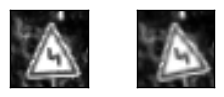

Source class: Speed limit (60km/h)
 Batch class: Speed limit (60km/h)


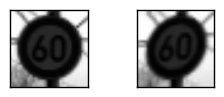

In [45]:
batch_iterator = AugmentedSignsBatchIterator(batch_size = 20)
for x_batch, y_batch in batch_iterator(X_train, y_train):
    for i in range(20): 
        print("Source class: " + class_name(y_train[i]) + "\n Batch class: " + class_name(y_batch[i]))
        # plot two images:
        fig = pyplot.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(X_train[i].reshape(image_size, image_size), cmap='gray')
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i].reshape(image_size, image_size), cmap='gray')
        pyplot.show()
    break

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [2]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.